# Quality evaluation of an image generation model

## FID

The Chamfer distance that we used in the previous notebook is a distance between point clouds. It is based on Euclidean distance, which works for low-dimensional data such as 2D points. For high-dimensional data such as images, the Euclidean distance is not a good measure, because the distance between two images can be high even if they are very similar.

The Fréchet Inception Distance (FID) is a metric that measures the distance between two distributions of images. A lower score means better quality. It is based on the Fréchet distance, which is a distance between Gaussian distributions. "Inception" here refers to a pre-trained Inception-v3 model, which is a convolutional neural network that was trained to classify images into 1000 categories. We can use the intermediate features of this model to measure the distance between two distributions of images.

The limitations of FID include:

- It assumes Gaussian distribution of features.
- It is sensitive to sample size and requires large sample sizes for stable estimates, which means it is computationally expensive.

Other metrics include:

- Inception Score (IS): measures both the diversity and quality of generated images. It may give misleading scores for specialized datasets (e.g., medical images, abstract art).
- LPIPS (Learned Perceptual Image Patch Similarity). It is good at measureing individual image quality, and more suitable for tasks like style transfer, image reconstruction.
- PSNR (Peak Signal-to-Noise Ratio). It measures pixel-level reconstruction quality,and does not measure perceptual quality.
- SSIM (Structural Similarity Index). It measures image quality based on luminance and contrast, and does not measure perceptual quality.
- Arena-style human evaluation: compare generated images from different models side by side, and ask human experts to choose the better one.

We are going to use the package`clean-fid`. As a santity check for the metric, let's take a pre-trained model from huggingface with known good quality, and see what the FID score looks like.

#### Install the package

In [1]:
!pip install clean-fid

Defaulting to user installation because normal site-packages is not writeable


### Load a pre-trained model

We are using the model released by Google, which is trained on CIFAR-10 dataset.


In [2]:
import torch, transformers, diffusers, xformers, torchvision
print("torch version:", torch.__version__)
print("transformers version:", transformers.__version__)
print("diffusers version:", diffusers.__version__)
print("xformers version:", xformers.__version__)
print("torchvision version:", torchvision.__version__)

torch version: 2.5.1+cu124
transformers version: 4.47.0
diffusers version: 0.31.0
xformers version: 0.0.28.post3
torchvision version: 0.20.1+cu124


In [3]:
%%time
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline

model_id = "google/ddpm-cifar10-32"

# load model and scheduler
ddpm = DDPMPipeline.from_pretrained(model_id)  # you can replace DDPMPipeline with DDIMPipeline or PNDMPipeline for faster inference
ddpm.set_progress_bar_config(disable=True)

2024-12-16 22:00:47.499784: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 22:00:47.512904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 22:00:47.527894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 22:00:47.532473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 22:00:47.543787: I tensorflow/core/platform/cpu_feature_guar

2024-12-16 22:00:48.384524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.


Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


CPU times: user 2.57 s, sys: 639 ms, total: 3.21 s
Wall time: 3.51 s


### Evaluate on 100 images

In [4]:
%%time
# run pipeline in inference (sample random noise and denoise)
from tqdm.notebook import tqdm
ddpm.to("cuda")

images = []
for _ in tqdm(range(9)):
    images += [i for i in ddpm(batch_size=100).images]


  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 13min 48s, sys: 272 ms, total: 13min 49s
Wall time: 13min 48s


Visualize the first image:

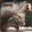

In [5]:
images[0]

#### Calculating FID on the first 100 images


In [6]:
%%time
# Save images

from pathlib import Path
import numpy as np
from cleanfid import fid

gen_path = Path("results/sampled_img_100")
gen_path.mkdir(exist_ok=True)

for i, img in enumerate(images[:100]):
    img_np = np.array(img)
    np.save(gen_path / f"{i}.npy", img_np)

score = fid.compute_fid(
            str(gen_path),
            dataset_name="cifar10",
            dataset_res=32,
            device="cuda",
            mode="clean",
            batch_size=2,
        )

print("FID score:", score)  # 156.41708381872482

compute FID of a folder with cifar10 statistics


Found 100 images in the folder results/sampled_img_100



FID sampled_img_100 :   0%|                                                                     | 0/50 [00:00<?, ?it/s]


FID sampled_img_100 :   2%|█▏                                                           | 1/50 [00:00<00:24,  1.96it/s]


FID sampled_img_100 :   4%|██▍                                                          | 2/50 [00:02<01:19,  1.66s/it]


FID sampled_img_100 :  40%|████████████████████████                                    | 20/50 [00:03<00:03,  9.26it/s]


FID sampled_img_100 :  78%|██████████████████████████████████████████████▊             | 39/50 [00:03<00:00, 20.85it/s]


FID sampled_img_100 : 100%|████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.31it/s]

FID score: 155.1173252056065
CPU times: user 57 s, sys: 7.68 s, total: 1min 4s
Wall time: 6.18 s


### First 1000 images



In [7]:
%%time
# Save images

gen_path = Path("results/sampled_img_1000")
gen_path.mkdir(exist_ok=True)

for i, img in enumerate(images[:1000]):
    img_np = np.array(img)
    np.save(gen_path / f"{i}.npy", img_np)

CPU times: user 341 ms, sys: 905 ms, total: 1.25 s
Wall time: 166 ms


In [8]:
%%time
from cleanfid import fid

score = fid.compute_fid(
            str(gen_path),
            dataset_name="cifar10",
            dataset_res=32,
            device="cuda",
            mode="clean",
            batch_size=2,
            verbose=False,
        )

print("FID score:", score)  # 44.02850054643022

FID score: 47.59607117774948
CPU times: user 50.7 s, sys: 7.36 s, total: 58.1 s
Wall time: 7.92 s


### 50k images

In [9]:
%%time
for _ in tqdm(range(490)):
    images += [i for i in ddpm(batch_size=100).images]

  0%|          | 0/490 [00:00<?, ?it/s]

CPU times: user 12h 36min 39s, sys: 6.73 s, total: 12h 36min 45s
Wall time: 12h 36min 32s


In [10]:
gen_path = Path("results/sampled_img_50k")
gen_path.mkdir(exist_ok=True)

for i, img in enumerate(images[:50000]):
    img_np = np.array(img)
    np.save(gen_path / f"{i}.npy", img_np)

In [11]:
%%time
score = fid.compute_fid(
            str(gen_path),
            dataset_name="cifar10",
            dataset_res=32,
            device="cuda",
            mode="clean",
            batch_size=2,
            verbose=False,
        )

CPU times: user 2min 53s, sys: 18.6 s, total: 3min 11s
Wall time: 2min 26s


In [12]:
print("FID score:", score)

FID score: 14.702197781209179


As you can see, FID score is sensitive to the sample size. From 100 to 1000 and then to 50k sampled images, we see the FID score decreases from 150 to about 50 and then to roughly 10. The recommended sample size is 50k, however, it takes a long time to sample.